In [26]:
from flax.core.scope import CollectionFilter
from netket.utils.types import PyTree
from netket.operator import Squared
from functools import partial, lru_cache
from typing import Callable, Optional

import jax
from jax import numpy as jnp
from flax.core.scope import CollectionFilter, DenyList  # noqa: F401

import netket as nk
from netket import jax as nkjax
from netket.operator import DiscreteOperator, Squared
from netket.stats import Stats
from netket.utils.types import PyTree
from netket.utils.dispatch import dispatch

from netket.vqs import expect_and_grad, expect_and_forces
from netket.vqs.mc.common import force_to_grad
from netket.stats import Stats
import time
import json
import matplotlib.pyplot as plt
import numpy as np

In [44]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero 
# Define a 1d chain
L = 6
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
hi = nk.hilbert.Spin(s=0.5, total_sz=0, N=g.n_nodes)
# calling the Heisenberg Hamiltonian
ha = nk.operator.Heisenberg(hilbert=hi, graph=g)

In [45]:
@nk.vqs.expect.dispatch
def expect_try(vstate: nk.vqs.FullSumState, Ô: nk.operator.DiscreteOperator) -> Stats:  # noqa: F811
#     _check_hilbert(vstate, Ô)

#     O = sparsify(Ô)
    O = Ô.to_sparse()
    Ψ = vstate.to_array()

    # TODO: This performs the full computation on all MPI ranks.
    # It would be great if we could split the computation among ranks.

    OΨ = O @ Ψ
    expval_O = (Ψ.conj() * OΨ).sum() 

    variance = jnp.sum(jnp.abs(OΨ - expval_O * Ψ) ** 2)
    return Stats(mean=expval_O, error_of_mean=0.0, variance=variance)

In [51]:
@expect_and_grad.dispatch
def expect_and_grad_fullsum(
    vstate: nk.vqs.FullSumState,
    Ô: nk.operator.DiscreteOperator,
    *args,
    mutable: CollectionFilter = False,
    use_covariance: Optional[bool] = None,
    **kwargs,
) -> tuple[Stats, PyTree]:
    if use_covariance is None:
        use_covariance = Ô.is_hermitian

    if use_covariance:
        # Implementation of expect_and_grad for `use_covariance == True` (due to the Literal[True]
        # type in the signature).` This case is equivalent to the composition of the
        # `expect_and_forces` and `force_to_grad` functions.
        # return expect_and_grad_from_covariance(vstate, Ô, *args, mutable=mutable)
        Ō, Ō_grad = expect_and_forces(vstate, Ô, *args, mutable=mutable, **kwargs)
        Ō_grad = force_to_grad(Ō_grad, vstate.parameters)
        return Ō, Ō_grad
    else:
        raise NotImplementedError(
            "The gradient of non hermitian operators with "
            "FullSumState is not yet implemented"
        )

@nk.vqs.expect_and_forces.dispatch
def expect_and_forces_fullsum(
    vstate: nk.vqs.FullSumState,
    Ô: nk.operator.DiscreteOperator,
    *,
    mutable: CollectionFilter = False,
) -> tuple[Stats, PyTree]:
    if isinstance(Ô, Squared):
        raise NotImplementedError("expect_and_forces not yet implemented for `Squared`")

#     _check_hilbert(vstate, Ô)

    O = Ô.to_sparse()
    Ψ = vstate.to_array()
    OΨ = O @ Ψ

    expval_O, Ō_grad, new_model_state = _exp_forces(
        vstate._apply_fun,
        mutable,
        vstate.parameters,
        vstate.model_state,
        vstate._all_states,
        OΨ,
        Ψ,
    )

    if mutable is not False:
        vstate.model_state = new_model_state

    return expval_O, Ō_grad


@partial(jax.jit, static_argnums=(0, 1))
def _exp_forces(
    model_apply_fun: Callable,
    mutable: CollectionFilter,
    parameters: PyTree,
    model_state: PyTree,
    σ: jnp.ndarray,
    OΨ: jnp.ndarray,
    Ψ: jnp.ndarray,
) -> tuple[PyTree, PyTree]:
    is_mutable = mutable is not False

    expval_O = (Ψ.conj() * OΨ).sum()
    variance = jnp.sum(jnp.abs(OΨ - expval_O * Ψ) ** 2)

    ΔOΨ = (OΨ - expval_O * Ψ).conj() * Ψ 

    
    _, vjp_fun, *new_model_state = nkjax.vjp(
        lambda w: model_apply_fun({"params": w, **model_state}, σ, mutable=mutable),
        parameters,
        conjugate=True,
        has_aux=is_mutable,
    )

    Ō_grad = vjp_fun(ΔOΨ)[0]

    new_model_state = new_model_state[0] if is_mutable else None

    return (
        Stats(mean=expval_O, error_of_mean=0.0, variance=variance),
        Ō_grad,
        new_model_state,
    )

In [58]:
(vs.to_array().conj() * ha.to_sparse()@vs.to_array()).sum()

Array(-4.13006836-1.11022302e-16j, dtype=complex128)

In [57]:
vs.to_array()

Array([ 5.43693790e-212+3.10929416e-212j,
        1.29475214e-142-1.05886220e-142j,
        2.09724453e-139+1.70873452e-140j,
       -3.22395137e-248-2.99714124e-248j,
       -1.08290122e-147-1.09209549e-147j,
       -1.07999650e-121-8.00971055e-122j,
       -2.76871070e-217-1.96755065e-217j,
        3.17015915e-262-5.28593673e-262j,
       -2.45211510e-088-1.64917002e-088j,
       -2.85171339e-164-1.51797559e-164j,
        3.16670245e-096-6.33989295e-096j,
        8.54306587e-174+2.83734596e-173j,
        4.67341036e-165+1.97266549e-164j,
        7.56118001e-187+1.28872990e-187j,
       -2.81074612e-001+7.48055361e-001j,
       -5.54119399e-179-1.37037898e-179j,
        6.37339101e-186-8.77194072e-185j,
       -5.02182953e-001-3.30488307e-001j,
        2.81110595e-147-1.45641202e-147j,
        1.84582354e-092-6.23938444e-092j], dtype=complex128)

In [56]:
ha.to_sparse()@vs.to_array()

array([-2.58950427e-142+2.11772440e-142j,
        5.62149225e-001-1.49611072e+000j,
        2.15999300e-121+1.60194211e-121j,
       -4.19448906e-139-3.41746904e-140j,
        1.00436591e+000+6.60976613e-001j,
        6.47997901e-121+4.80582633e-121j,
        4.90423021e-088+3.29834004e-088j,
        4.90386104e-088+3.29958791e-088j,
        5.62149225e-001-1.49611072e+000j,
        4.90423021e-088+3.29834004e-088j,
        6.33340489e-096-1.26797859e-095j,
       -6.33340489e-096+1.26797859e-095j,
        5.62149225e-001-1.49611072e+000j,
        5.62149225e-001-1.49611072e+000j,
        2.69081358e+000-3.82735555e+000j,
        5.62149225e-001-1.49611072e+000j,
        1.00436591e+000+6.60976613e-001j,
        1.56651513e+000-8.35134108e-001j,
        1.00436591e+000+6.60976613e-001j,
        3.69164709e-092-1.24787689e-091j])

In [52]:
# Build the sampler
# sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)
ma = nk.models.RBM(alpha=1, param_dtype=complex)
vs = nk.vqs.FullSumState(hi, ma)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.001)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1, holomorphic=True)


# The ground-state optimization loop
Target_ha = ha@ha
gs = nk.VMC(
    hamiltonian=Target_ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(10000, out='RBM')
end = time.time()

100%|█| 10000/10000 [00:15<00:00, 665.58it/s, Energy=4.336e+01+8.882e-16j ± 0.00


In [53]:
data=json.load(open("RBM.log"))

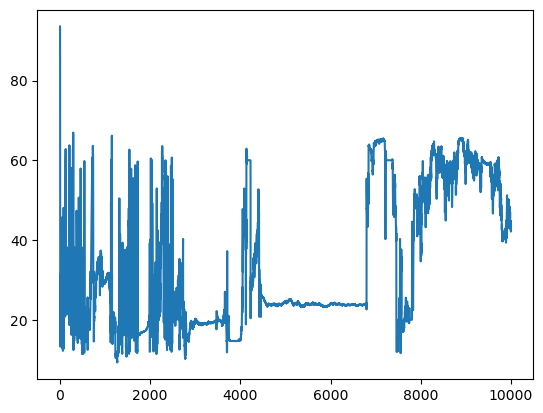

In [54]:
plt.plot(data['Energy']['Mean']['real'])

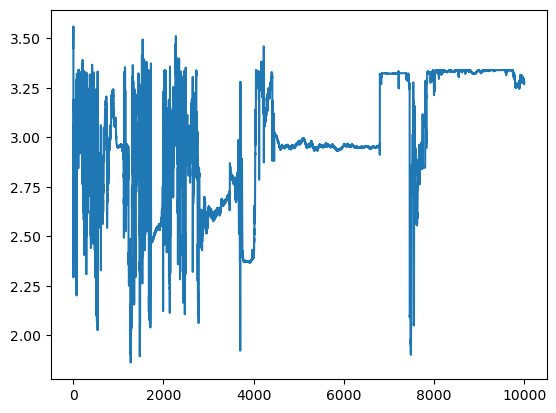

In [55]:
plt.plot(np.log10(data['Energy']['Variance']))